# Prédiction de la consommation - Nested CV : Validation croisée

Nous allons dans ce notebook croiser 3 modèles de machine learning pour essayer de prévoir la consommation électrique française : 
- Par mois
- Par jours

Nous testons dans ce notebook les 3 modèles suivants :
  - La PLS Regression
  - Les forêts aléatoires
  - Les vecteurs de regression

In [2]:
### IMPORT DES PACKAGES ###
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import explained_variance_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
### LECTURE DES DONNEES ET DATA CLEANING ###
df = pd.read_csv('clean_data/data_meteo_prod.csv', header=0, parse_dates=[0],  index_col=14,squeeze=True)

df['rafales_sur_une_periode']=df['rafales_sur_une_periode'].astype(float)

colonne_inutile =['regioncode', 'latitude', 'longitude', 'altitude',
                  'thermique_mw', 'nucleaire_mw', 'eolien_mw', 'solaire_mw',
                  'hydraulique_mw', 'pompage_mw', 'bioenergies_mw', 'ech._physiques_mw',
                  'prod_totale']

df= df.drop(colonne_inutile, axis=1)

df.index= pd.to_datetime(df.index)

### Instanciation des modèles et des paramètres à tester : 

In [5]:
pls = PLSRegression ()
rf = RandomForestRegressor ()
svr = SVR ()

param_grid_pls = {'n_components': range(1,10), 'scale': [False, True]}

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                        'min_samples_leaf': [1, 3, 5],
                        'max_features': ['auto', 'sqrt', 'log2']}]

param_grid_svr = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
                  {'kernel': ['linear'], 'C': np.logspace(-4, 4, 9)},
                  {'kernel': ['poly'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
                  {'kernel': ['sigmoid'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
                 ]

### Instanciation d'un dictionnaire et d'un GridSearch pour chaque algo :

In [6]:
gridcvs = {}

for pgrid, clf, name in zip((param_grid_pls, param_grid_rf, param_grid_svr),
                            (pls, rf, svr),
                            ('PLSRegression', 'RF', 'SVR')):
    gcv = GridSearchCV(clf, pgrid, cv=KFold(2), refit=True)
    gridcvs[name] = gcv

# Test des modèles par mois :

### Preprocessing et séparation des jeux d'entrainement et de test :

In [5]:
function_to_apply = {
    'rafales_sur_une_periode' : 'max',
    'variation_de_pression_en_3_heures' : 'sum',
    'precipitations_dans_les_3_dernieres_heures' : 'sum',
    'pression_station' : 'mean',
    'pression_au_niveau_mer' : 'mean',
    'direction_du_vent_moyen' : 'median', #médiane de la direction sur la journée
    'vitesse_du_vent_moyen' : 'mean',
    'humidite' : 'mean',
    'point_de_rosee' : 'mean',
    'temperature_c' : 'mean',
    'consommation_mw' : 'sum',
}

df_mois= df.resample('M').agg(function_to_apply)

Y = df_mois['consommation_mw']
X = df_mois.drop('consommation_mw', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

### Création de la boucle de testing :
*lorsqu'une étape de preprocessing (supervisée) est nécessaire, elle doit être réalisée à l'intérieur de la boucle interne de la validation croisée (avant l'échantillonnage). Sinon, une fuite d'information sur les données est possible vers l'ensemble de validation à chaque étape d'évaluation, ce qui donnerait une estimation finale trop optimiste.*

In [6]:
warnings.filterwarnings("ignore")

outer_cv = KFold(2)

outer_scores = {}

scaler = StandardScaler()

print('Calcul en cours...')
for keys, value in gridcvs.items():
    X_train_scaled = scaler.fit_transform(X_train)
    score = cross_val_score(value, X_train_scaled, y_train, cv = outer_cv)
    outer_scores[keys] = score
    print(f'{keys}: outer score {100*score.mean():.2f} +/- {100*score.std():.2f}') 

Calcul en cours...
PLSRegression: outer score 86.81 +/- 0.26
RF: outer score 92.07 +/- 2.04
SVR: outer score 59.64 +/- 6.46


Nous obtenons des scores très encourageant ! **Le random forest semble être l'algorithme le plus précis ! Entrainons celui-ci et déterminons les meilleurs paramètres.**

In [9]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_reg = gridcvs['RF']
final_reg.fit(X_train_scaled, y_train)

print(f'Best Parameters: {final_reg.best_params_}')

train_score = explained_variance_score(y_true=y_train, y_pred=final_reg.predict(X_train_scaled))
test_score = explained_variance_score(y_true=y_test, y_pred=final_reg.predict(X_test_scaled))

print('Training score:',train_score)
print('Test score:', test_score)

Best Parameters: {'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}
Training score: 0.9908303129487486
Test score: 0.9605415137321619


Le scoring est plus que satisfaisant même sur les données tests. La météo permet de prédire la consommation d'électricité. 

#### Affichons les résultats graphiquement :

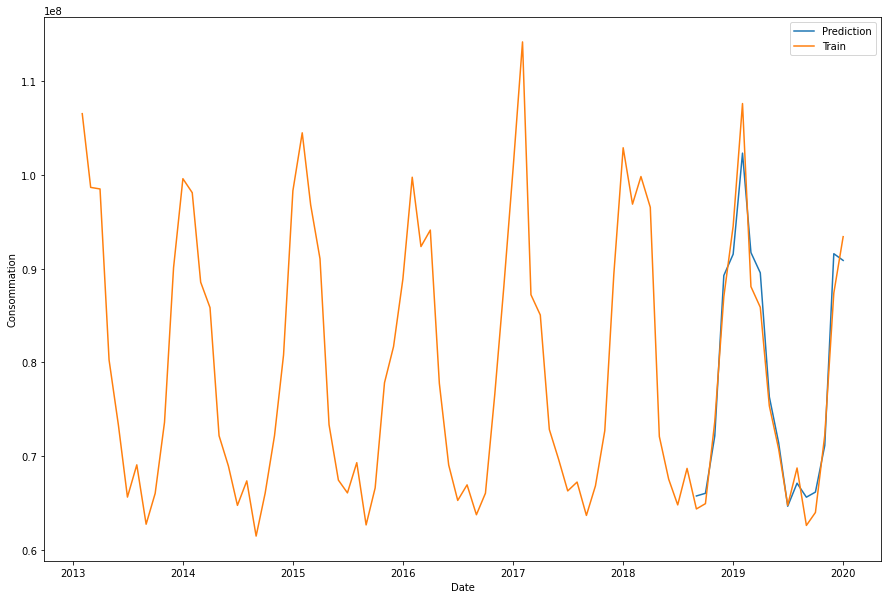

In [12]:
y_pred = final_reg.predict(X_test_scaled)

plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_pred, label='Prediction')
plt.plot(Y, label='Train')

plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show();

# Test des modèles par jours :

**Nous nous limiterons à l'année 2018 - 2019 pour cette partie.**

## Preprocessing et séparation des jeux d'entrainement et de test :

In [13]:
function_to_apply = {
    'rafales_sur_une_periode' : 'max',
    'variation_de_pression_en_3_heures' : 'sum',
    'precipitations_dans_les_3_dernieres_heures' : 'sum',
    'pression_station' : 'mean',
    'pression_au_niveau_mer' : 'mean',
    'direction_du_vent_moyen' : 'median', #médiane de la direction sur la journée
    'vitesse_du_vent_moyen' : 'mean',
    'humidite' : 'mean',
    'point_de_rosee' : 'mean',
    'temperature_c' : 'mean',
    'consommation_mw' : 'sum',
}
df_day = df.resample('D').agg(function_to_apply)
df_day = df_day.loc['2018':]

Y = df_day['consommation_mw']
X = df_day.drop('consommation_mw', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Création de la boucle de testing :

In [14]:
warnings.filterwarnings("ignore")

outer_cv = KFold(2)

outer_scores = {}

scaler = StandardScaler()

print('Calcul en cours...')
for keys, value in gridcvs.items():
    X_train_scaled = scaler.fit_transform(X_train)
    score = cross_val_score(value, X_train_scaled, y_train, cv = outer_cv)
    outer_scores[keys] = score
    print(f'{keys}: outer score {100*score.mean():.2f} +/- {100*score.std():.2f}') 

Calcul en cours...
PLSRegression: outer score 60.29 +/- 12.78
RF: outer score 81.28 +/- 4.36
SVR: outer score 57.31 +/- 14.53


Nous obtenons des scores **moins encourageant pour une granularité par jours** ! Le random forest semble être l'algorithme le plus précis des 3. Entrainons celui-ci et déterminons les meilleurs paramètres.

In [15]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_reg = gridcvs['RF']
final_reg.fit(X_train_scaled, y_train)

print(f'Best Parameters: {final_reg.best_params_}')

train_score = explained_variance_score(y_true=y_train, y_pred=final_reg.predict(X_train_scaled))
test_score = explained_variance_score(y_true=y_test, y_pred=final_reg.predict(X_test_scaled))

print('Training score:',train_score)
print('Test score:', test_score)

Best Parameters: {'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 1000}
Training score: 0.9812905677671295
Test score: 0.8323868882464839


Le scoring est assez satisfaisant même sur les données tests. 

#### Voyons la représentation graphique :

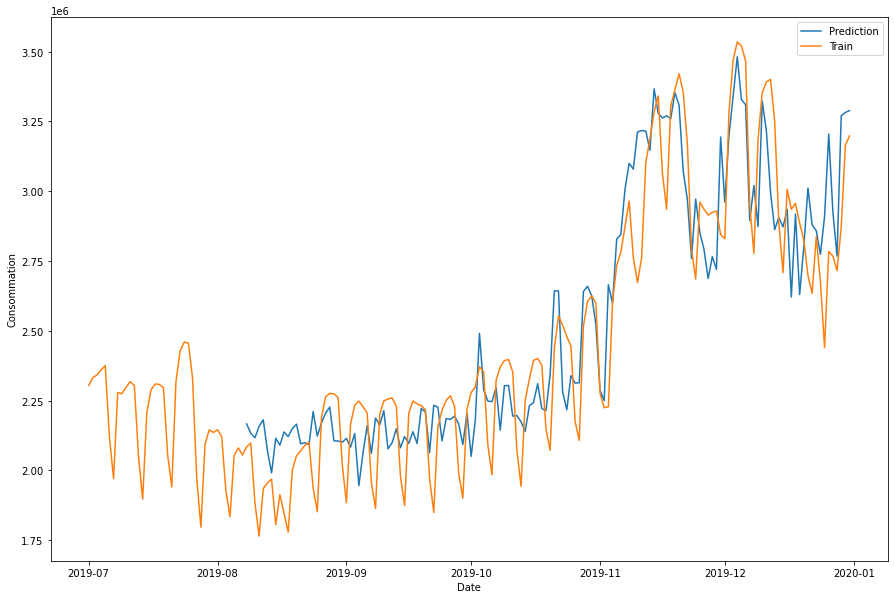

In [17]:
y_pred = final_reg.predict(X_test_scaled)

plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_pred, label='Prediction')
plt.plot(Y['2019-07-01':], label='Train')

plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show();

Pour une granularité plus élevé, le modèle des forêts aléatoires **ne capte pas très bien les effets de saisonnalité** de la consommation électrique française. 

Il va falloir essayer un modèle plus précis : le modèle SARIMA (avec et sans valeur exogène)

# Test des modèles par 3h :

In [3]:
FILEPATH = 'clean_data//ener_conso_full.csv'
FILEPATH2 = 'clean_data/clean_data_meteo_3h.csv'

conso = pd.read_csv(FILEPATH, parse_dates=[0], index_col=0, squeeze=True)
meteo = pd.read_csv(FILEPATH2)
conso = conso.resample('3H').sum()
to_drop = ['regioncode','latitude', 'longitude', 'altitude',]

meteo = meteo.drop(to_drop, axis=1)
meteo['date'] = pd.to_datetime(meteo['date'])
meteo = meteo.set_index('date')
meteo = meteo['2019-12-01' : '2019-12-31']
conso = conso['2019-12-01' : '2019-12-31']

X_train, X_test, y_train, y_test = train_test_split(meteo, conso, test_size=0.2, shuffle=False)

In [7]:
warnings.filterwarnings("ignore")

outer_cv = KFold(2)

outer_scores = {}

scaler = StandardScaler()

print('Calcul en cours...')
for keys, value in gridcvs.items():
    X_train_scaled = scaler.fit_transform(X_train)
    score = cross_val_score(value, X_train_scaled, y_train, cv = outer_cv)
    outer_scores[keys] = score
    print(f'{keys}: outer score {100*score.mean():.2f} +/- {100*score.std():.2f}') 

Calcul en cours...
PLSRegression: outer score -291.07 +/- 216.33
RF: outer score -199.35 +/- 111.99
SVR: outer score -166.75 +/- 74.71


In [8]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_reg = gridcvs['RF']
final_reg.fit(X_train_scaled, y_train)

print(f'Best Parameters: {final_reg.best_params_}')

train_score = explained_variance_score(y_true=y_train, y_pred=final_reg.predict(X_train_scaled))
test_score = explained_variance_score(y_true=y_test, y_pred=final_reg.predict(X_test_scaled))

print('Training score:',train_score)
print('Test score:', test_score)

Best Parameters: {'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 50}
Training score: 0.7199973569789877
Test score: -0.34204512905018203


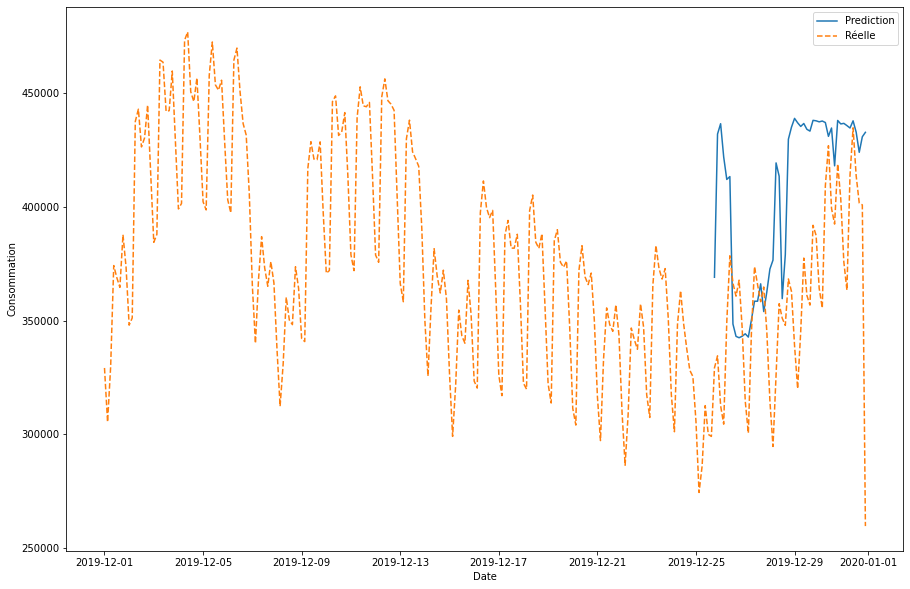

In [10]:
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_pred, label='Prediction')
plt.plot(conso['2019-12-01':], label='Réelle', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Consommation')
plt.legend()
plt.show();